## From Noise to Notes: A Diffusion-Based Cleanup

### Importing the libraries

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar
import os
import time
from scipy import ndimage #for running faster and optimization

### adding salt & pepper noise to the image

Found 25 images in the input folder.


100%|██████████| 25/25 [00:12<00:00,  1.98it/s]


Processed images saved to C:\Users\Arian\Desktop\Original pictures\Compressed


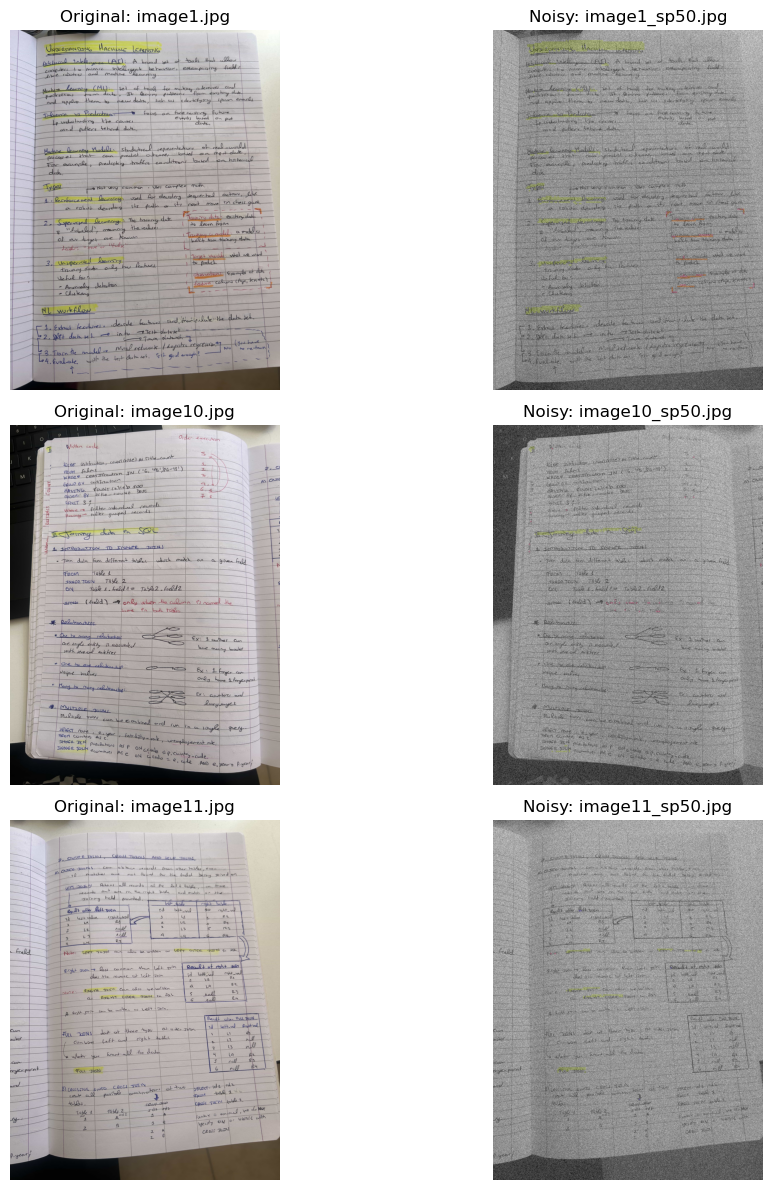

In [15]:
def add_salt_and_pepper_noise(image: np.ndarray,
                              amount: float = 0.2,
                              salt_vs_pepper: float = 0.5) -> np.ndarray:
    """
    Adds salt-and-pepper noise to an image.
    
    Parameters:
      image           : H×W×C uint8 image array (0–255)
      amount          : fraction of pixels to corrupt (e.g. 0.2 for 20%)
      salt_vs_pepper  : fraction of salt vs pepper noise (0.5 means 50% salt, 50% pepper)
    
    Returns:
      noisy_image : same shape as input, with noise applied
    """
    noisy = image.copy()
    h, w, c = noisy.shape
    num_pixels = int(amount * h * w)
    
    # Salt (white) noise
    num_salt   = int(salt_vs_pepper * num_pixels)
    ys = np.random.randint(0, h, num_salt)
    xs = np.random.randint(0, w, num_salt)
    noisy[ys, xs] = 255  # white
    
    # Pepper (black) noise
    num_pepper = num_pixels - num_salt
    ys = np.random.randint(0, h, num_pepper)
    xs = np.random.randint(0, w, num_pepper)
    noisy[ys, xs] = 0    # black
    
    return noisy

def process_image_dataset(input_folder, output_folder, amount=0.5, salt_vs_pepper=0.5):
    """
    Process all images in the input folder, add salt and pepper noise, and save to output folder.
    
    Parameters:
        input_folder: Path to folder containing original images
        output_folder: Path to save noisy images
        amount: Amount of noise to add
        salt_vs_pepper: Ratio of salt vs pepper
    """
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Get all image files
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    image_files = [f for f in os.listdir(input_folder) 
                  if os.path.isfile(os.path.join(input_folder, f)) and 
                  os.path.splitext(f.lower())[1] in image_extensions]
    
    print(f"Found {len(image_files)} images in the input folder.")
    
    # Set JPEG compression quality (0-100, lower = smaller file size)
    jpeg_quality = 4  # Adjust as needed
    
    # Process each image
    for image_file in tqdm(image_files):
        # Full path to input file
        input_path = os.path.join(input_folder, image_file)
        
        # Generate output filename
        filename, ext = os.path.splitext(image_file)
        output_filename = f"{filename}_sp{int(amount*100)}{ext}"
        output_path = os.path.join(output_folder, output_filename)
        
        # Load, process and save
        img = cv2.imread(input_path)
        if img is None:
            print(f"Warning: Could not read {input_path}")
            continue
            
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        noisy_img = add_salt_and_pepper_noise(img_rgb, amount=amount, salt_vs_pepper=salt_vs_pepper)
        noisy_bgr = cv2.cvtColor(noisy_img, cv2.COLOR_RGB2BGR)
        
        # Save the result with compression for JPEG files
        if ext.lower() in ['.jpg', '.jpeg']:
            cv2.imwrite(output_path, noisy_bgr, [cv2.IMWRITE_JPEG_QUALITY, jpeg_quality])
        else:
            cv2.imwrite(output_path, noisy_bgr)
    
    print(f"Processed images saved to {output_folder}")

# Example usage:
input_folder = r"C:\Users\Arian\Desktop\Original pictures\Original"
output_folder = r"C:\Users\Arian\Desktop\Original pictures\Compressed"

# Process all images with 50% salt and pepper noise
process_image_dataset(input_folder, output_folder, amount=0.5, salt_vs_pepper=0.5)

# Optional: Show a preview of first few images before and after
def show_examples(input_folder, output_folder, num_examples=3):
    """Show a few examples of original and noisy images"""
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    image_files = [f for f in os.listdir(input_folder) 
                  if os.path.isfile(os.path.join(input_folder, f)) and 
                  os.path.splitext(f.lower())[1] in image_extensions]
    
    if len(image_files) == 0:
        print("No images found to display")
        return
        
    n = min(num_examples, len(image_files))
    plt.figure(figsize=(12, 4*n))
    
    for i in range(n):
        # Original image
        img_path = os.path.join(input_folder, image_files[i])
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Noisy image
        filename, ext = os.path.splitext(image_files[i])
        noisy_filename = f"{filename}_sp50{ext}"
        noisy_path = os.path.join(output_folder, noisy_filename)
        
        if os.path.exists(noisy_path):
            noisy_img = cv2.imread(noisy_path)
            noisy_img_rgb = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)
            
            plt.subplot(n, 2, i*2+1)
            plt.title(f"Original: {image_files[i]}")
            plt.imshow(img_rgb)
            plt.axis("off")
            
            plt.subplot(n, 2, i*2+2)
            plt.title(f"Noisy: {noisy_filename}")
            plt.imshow(noisy_img_rgb)
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Show a few examples
show_examples(input_folder, output_folder, num_examples=3)

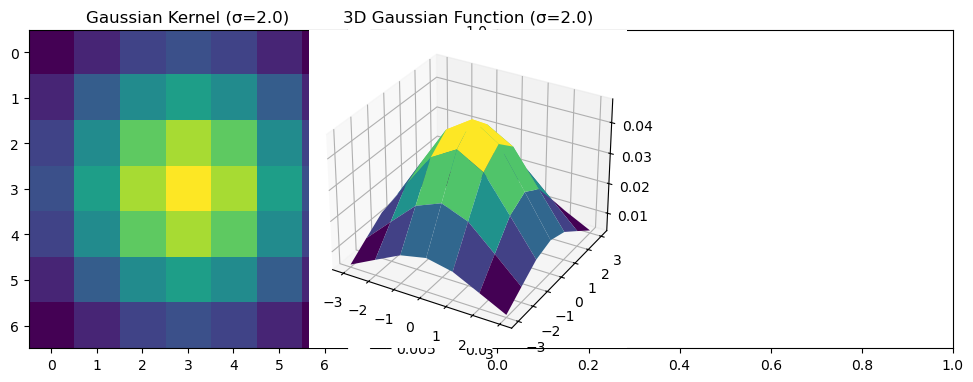

Applying Gaussian filter (OpenCV implementation)...
Processing completed in 0.41 seconds


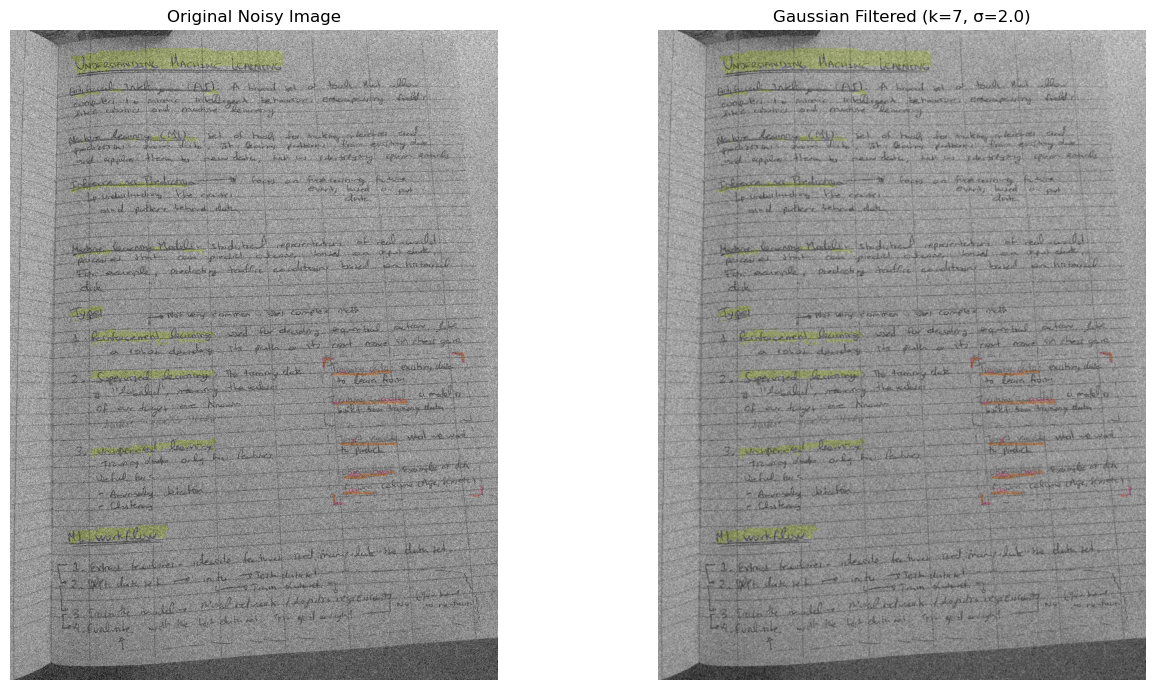

In [16]:
def apply_gaussian_to_single_image_opencv(image_path, kernel_size=5, sigma=1.0):
    """
    Apply the Gaussian filter to a single image using OpenCV.
    Still visualizes the kernel for educational purposes.
    
    Parameters:
        image_path: Path to the noisy image
        kernel_size: Size of the Gaussian kernel (must be odd)
        sigma: Standard deviation of the Gaussian distribution
    """
    # Load the image
    start_time = time.time()
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image at {image_path}")
        return None
    
    # Convert to RGB for display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create Gaussian kernel (for visualization)
    # Ensure kernel size is odd
    if kernel_size % 2 == 0:
        kernel_size += 1
        
    # Generate the grid of coordinates centered at 0
    k = kernel_size // 2
    x, y = np.mgrid[-k:k+1, -k:k+1]
    
    # Create the Gaussian kernel: G(x,y) = (1/(2πσ²)) * exp(-(x²+y²)/(2σ²))
    normal = 1 / (2.0 * np.pi * sigma**2)
    kernel = np.exp(-((x**2 + y**2) / (2.0 * sigma**2))) * normal
    
    # Normalize the kernel to ensure it sums to 1
    kernel = kernel / np.sum(kernel)
    
    # Display the kernel
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(kernel, cmap='viridis')
    plt.title(f'Gaussian Kernel (σ={sigma})')
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x, y, kernel, cmap='viridis')
    ax.set_title(f'3D Gaussian Function (σ={sigma})')
    plt.tight_layout()
    plt.show()
    
    # Apply Gaussian blur using OpenCV (much faster!)
    print("Applying Gaussian filter (OpenCV implementation)...")
    filtered_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
    
    # Convert back to RGB for display
    filtered_image_rgb = cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB)
    
    total_time = time.time() - start_time
    print(f"Processing completed in {total_time:.2f} seconds")
    
    # Display the results side by side
    plt.figure(figsize=(14, 7))
    
    # Original noisy image
    plt.subplot(1, 2, 1)
    plt.title('Original Noisy Image')
    plt.imshow(image_rgb)
    plt.axis('off')
    
    # Filtered image
    plt.subplot(1, 2, 2)
    plt.title(f'Gaussian Filtered (k={kernel_size}, σ={sigma})')
    plt.imshow(filtered_image_rgb)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return filtered_image

# Apply to a single image with custom parameters
noisy_image_path = r"C:\Users\Arian\Desktop\Original pictures\Compressed\image1_sp50.jpg"
result_opencv = apply_gaussian_to_single_image_opencv(
    noisy_image_path, 
    kernel_size=7,  # Adjust kernel size as needed
    sigma=2.0       # Adjust sigma as needed
)

Applying median filter with kernel size 7×7 (OpenCV implementation)...
Processing completed in 1.11 seconds


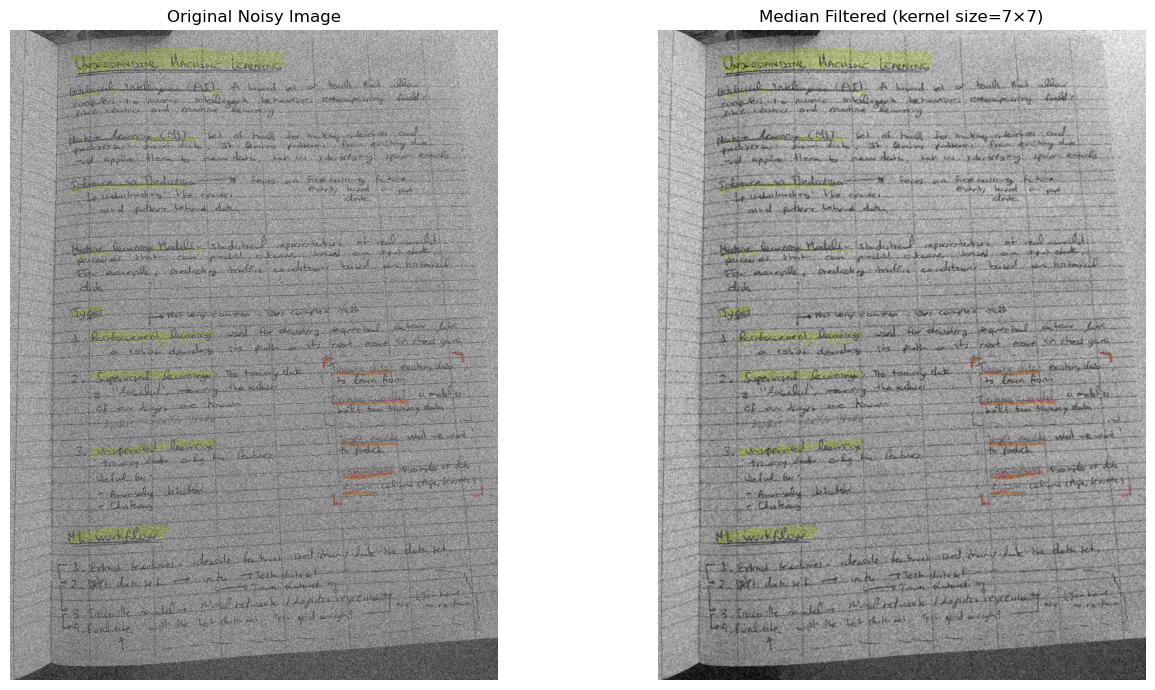

In [17]:
def apply_median_to_single_image_opencv(image_path, kernel_size=3):
    """
    Apply a median filter to a single image using OpenCV.
    Still explains the median filter concept but uses OpenCV's fast implementation.
    
    The median filter works as follows:
    1. For each pixel in the image:
       - Extract a window of size kernel_size × kernel_size centered at the pixel
       - Sort all values in the window
       - Replace the pixel with the median value from the sorted list
    
    Parameters:
        image_path: Path to the noisy image
        kernel_size: Size of the median kernel (must be odd)
    
    Returns:
        filtered_image: The median filtered image
    """
    # Load the image
    start_time = time.time()
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image at {image_path}")
        return None
    
    # Convert to RGB for display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Ensure kernel size is odd
    if kernel_size % 2 == 0:
        kernel_size += 1
        print(f"Adjusted kernel size to {kernel_size} (must be odd)")
    
    # Apply median filter using OpenCV (much faster!)
    print(f"Applying median filter with kernel size {kernel_size}×{kernel_size} (OpenCV implementation)...")
    filtered_image = cv2.medianBlur(image, kernel_size)
    
    # Convert filtered image to RGB for display
    filtered_image_rgb = cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB)
    
    total_time = time.time() - start_time
    print(f"Processing completed in {total_time:.2f} seconds")
    
    # Display the results side by side
    plt.figure(figsize=(14, 7))
    
    # Original noisy image
    plt.subplot(1, 2, 1)
    plt.title('Original Noisy Image')
    plt.imshow(image_rgb)
    plt.axis('off')
    
    # Filtered image
    plt.subplot(1, 2, 2)
    plt.title(f'Median Filtered (kernel size={kernel_size}×{kernel_size})')
    plt.imshow(filtered_image_rgb)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return filtered_image

# Example usage
noisy_image_path = r"C:\Users\Arian\Desktop\Original pictures\Compressed\image1_sp50.jpg"
result_median_opencv = apply_median_to_single_image_opencv(
    noisy_image_path, 
    kernel_size=7  # Start with a smaller kernel size, can increase for more filtering
)